 ## Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow import keras

import numpy as np
import os
import glob
import cv2
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


 ## Reading Data

In [2]:

imgs = []
labels = []
max1, max2 = 0,0
if not os.path.isfile('imgs.npy'):
    path = './../data/Q3/Core_Point/'

    # r=root, d=directories, f = files
    # r = os.walk(path+"Data/")
    files = [f for f in glob.glob(path + "Data/*.jpeg", recursive=True)]
    # fpaths = [path+"Data/"+i for i in files]
    
    for f in files:
        # print(f, "\n")
        im = cv2.imread(f,0)
        im = np.asarray(im)
        max1, max2 = max(max1, im.shape[0]), max(max2, im.shape[1])
        # a = np.asarray(im)
        # a = np.pad(a,((0,480-a.shape[0]),(0,640-a.shape[1])), 'constant', constant_values=(0, 0))
        imgs.append(im)

        f = f.replace("Data", "Ground_truth" )
        f = f.replace(".jpeg", "_gt.txt")
       
        fi = open(f, "r")
        st = fi.read().split(" ")
        labels.append(np.asarray(st)[:2])
        # print(st,"\n")

    print(max1, max2)
    np.save("dims.npy", [max1, max2])

    img = []
    for i in imgs:
        i = np.asarray(i)
        i = np.pad(i,((0,max1-i.shape[0]),(0,max2-i.shape[1])), 'constant', constant_values=(0, 0))
        img.append(i)


    imgs = np.asarray(img, dtype=np.uint8)
    labels = np.asarray(labels, dtype=int)

    np.save("./imgs.npy", imgs)
    np.save("./labels.npy", labels)

else:
    imgs = np.load("imgs.npy")
    labels = np.load("labels.npy")
    max1, max2 = np.load("dims.npy")
    

 ## Function for printing predicted Image

In [3]:
def showim(inimg, loc):
    loc[0] = int(loc[0])
    loc[1] = int(loc[1])
    x1 = range(loc[0])
    y1 = np.ones(shape=loc[0], dtype=int)*loc[1]

    x2 = range(loc[1])
    y2 = np.ones(shape=loc[1], dtype=int)*loc[0]
    fig, ax = plt.subplots()
    ax.imshow(inimg)
    ax.plot(y1, x1,  linewidth=2, color='firebrick')
    ax.plot(x2, y2,  linewidth=2, color='firebrick')
    plt.show()



 ## Building Network

In [4]:

lines_input = Input(shape=(max1, max2,1), name='line')
x = layers.Conv2D(32, (3, 3), activation='relu')(lines_input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(4, 4),strides=2)(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(4, 4),strides=2)(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(4, 4),strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(4, 4),strides=2)(x)
x = layers.Flatten()(x)

reg = layers.Dense(100,activation='relu')(x)
reg = layers.Dense(2, activation='relu', name='box')(reg)

model = Model(lines_input,reg)

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
line (InputLayer)            (None, 560, 352, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 558, 350, 32)      320       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 558, 350, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 278, 174, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 276, 172, 32)      9248      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 276, 172, 32)      128       
______________________

 ## Setting Data Variables

In [5]:
X = imgs #[0:1000]
Y = labels #[0:1000]

X_test = imgs[300:400]
Y_test = labels[300:400]


 ## Plot sample input image

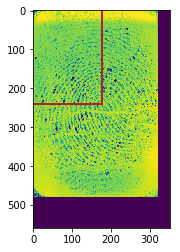

In [6]:
x1 = range(Y[0][0])
y1 = np.ones(shape=Y[0][0], dtype=int)*Y[0][1]

x2 = range(Y[0][1])
y2 = np.ones(shape=Y[0][1], dtype=int)*Y[0][0]

fig, ax = plt.subplots()
ax.imshow(X[0])
ax.plot(y1, x1,  linewidth=2, color='firebrick')
ax.plot(x2, y2,  linewidth=2, color='firebrick')
plt.show()



 ## Training

In [7]:


X = X.reshape(-1,max1,max2,1)
X_test = X_test.reshape(-1, max1, max2, 1)

history = model.fit(X,Y, 
                    epochs=1, 
                    batch_size=4,
                    validation_split=0.1,
                    verbose=1)

model.save('q3.h5')

Train on 3600 samples, validate on 400 samples
Instructions for updating:
Use tf.cast instead.
3600/3600 [==============================] - 294s 82ms/sample - loss: 2037.0353 - acc: 0.9483 - val_loss: 2455.4548 - val_acc: 0.9600


 ## Prediction

In [8]:
M = model.predict(X)
# print(Y_test)
print(M.shape)
np.save("Predictions.npy", M)

# model.save('mukul_net.h5')



(4000, 2)


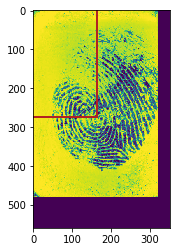

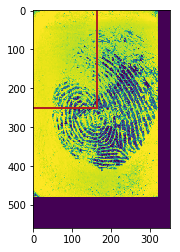

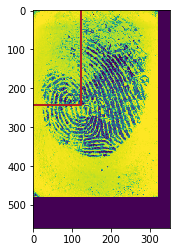

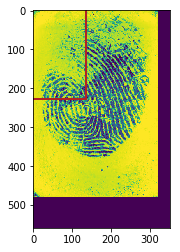

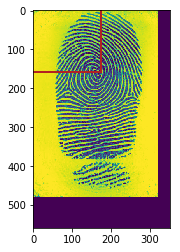

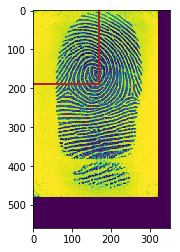

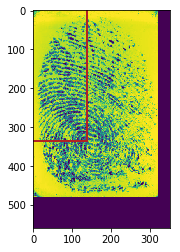

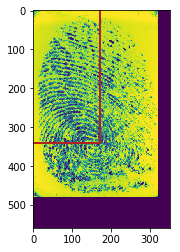

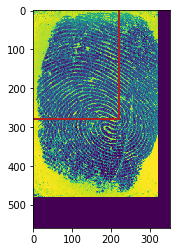

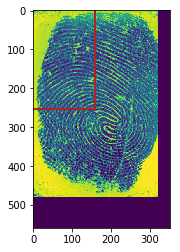

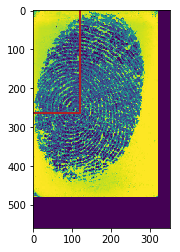

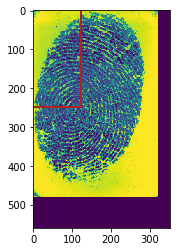

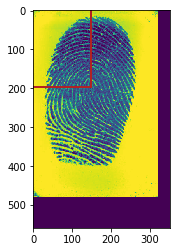

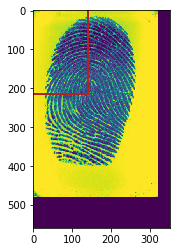

In [9]:
# print(M.shape)
M = np.load("Predictions.npy")
for i in range(3500,3507):
    # showim(X[i], Y[i])
    M = M.astype(int)
    showim(X[i].reshape(max1, max2), Y[i])
    showim(X[i].reshape(max1, max2), M[i])
